<a href="https://colab.research.google.com/github/Tower5954/TensorFlow/blob/main/06_Transfer_Learning_Scaling_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning part.3

What we are going to cover:
* Downloading and preparing 10% of all Food101 classes (7500+ training images)
* Training a transfer learning feature extraction model
* Fine-tuning a feature extraction model to beat the original Food101 paper with only 10% of the data.
* Evaluating "Food Visions mini" predictions.
  * Finding the most wrong predictions (on the test data)
* Making predictions with Food Vision mini on our own custom data.

We have now seen the power of transfer learning feature extraction and fine-tuning, now it is time to scale up to all of the classes in food101 (101 total classes of food).

The goal is to beat the original food 101 paper with only 10% of the training (leveraging the power of deep learning).

 [Original Food101 paper.](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)

 The baseline to beat is 50.76% accuracy across 101 classes.

In [2]:
# Set up GPU 
# Check to see if running a GPU

!nvidia-smi

Tue Jan 25 20:49:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we have created a series of helper functions.

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-01-25 20:49:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-25 20:49:13 (72.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data.

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

> The data that we are downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [5]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2022-01-25 20:49:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.31.128, 142.251.111.128, 142.250.73.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   192MB/s    in 8.4s    

2022-01-25 20:49:24 (186 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



### Checking the data

In [6]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/peking_duck'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/gyoza'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/deviled_eggs'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sashimi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/caprese_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/takoyaki'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_quesadilla'.
There are 0 directories and 250 images in '101_food_cl

In [7]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis 

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big model with transfer learning on 10% of the 101 Food Classes

The steps that we will take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we will create our output layer)
* Compile the model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)
 

### Create checkpoint callback

In [8]:
checkpoint_path = "101_classes_10_percent_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True) 

### Create data augmentation

In [9]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.keras.models import Sequential 

# Setup data augmentation
data_augmentation = Sequential([
                      preprocessing.RandomFlip("horizontal"),
                      preprocessing.RandomRotation(0.2),
                      preprocessing.RandomHeight(0.2),
                      preprocessing.RandomWidth(0.2),
                      preprocessing.RandomZoom(0.2),
                     # preprocessing.Rescaling(1/255.) # rescale inputs of images to between 0 & 1, required for models like ResNet50
                     
                      ],name="data-augmentation")

### Set up the base model and freeze it's layers (this will extract features)

In [10]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers

inputs = layers.Input(shape=(224,224,3), name='input_layer')
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay frozen.
x = layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [11]:
# Get a summary of the model we have created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data-augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

### Compile the Model

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

### Fit the model

In [13]:
history_101_classes_10_percent_model = model.fit(train_data_all_10_percent,
                                                 epochs=5,
                                                 validation_data=test_data,
                                                 validation_steps=int(0.15*len(test_data)),
                                                 callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 88s 311ms/step - loss: 3.4812 - accuracy: 0.2466 - val_loss: 2.7171 - val_accuracy: 0.3943
Epoch 2/5
237/237 [==============================] - 60s 250ms/step - loss: 2.3438 - accuracy: 0.4688 - val_loss: 2.2841 - val_accuracy: 0.4547
Epoch 3/5
237/237 [==============================] - 54s 227ms/step - loss: 1.9831 - accuracy: 0.5314 - val_loss: 2.1402 - val_accuracy: 0.4690
Epoch 4/5
237/237 [==============================] - 51s 214ms/step - loss: 1.7666 - accuracy: 0.5717 - val_loss: 2.0636 - val_accuracy: 0.4783
Epoch 5/5
237/237 [==============================] - 47s 198ms/step - loss: 1.6042 - accuracy: 0.6057 - val_loss: 1.9649 - val_accuracy: 0.4955


### Evaluate the model 

In [14]:
fine_tuning_results = model.evaluate(test_data)

790/790 [==============================] - 60s 76ms/step - loss: 1.7114 - accuracy: 0.5520


In [15]:
fine_tuning_results

[1.7114171981811523, 0.5519999861717224]

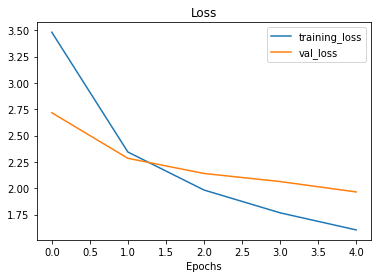

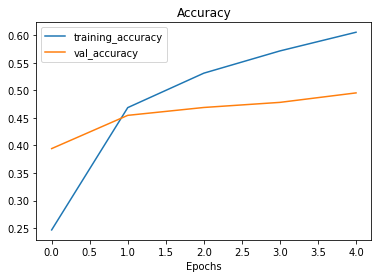

In [16]:
plot_loss_curves(history_101_classes_10_percent_model)

## Fine-tuning

Unfreeze all of the layers in the base model.

In [17]:
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False


In [18]:
# Recompile model with a lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #learning rate lowered by 10x 
              metrics=['accuracy'])

In [19]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data-augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [20]:
# Check which layers are trainable in the base_model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [22]:
# Fine tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), this is the total number of epochs we are after

# Fine-tune the model 
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs = fine_tune_epochs,
                                                     validation_data = test_data,
                                                     validation_steps = int(0.15* len(test_data)),
                                                     initial_epoch=history_101_classes_10_percent_model.epoch[-1])

Epoch 5/10
237/237 [==============================] - 56s 197ms/step - loss: 1.3539 - accuracy: 0.6474 - val_loss: 1.9338 - val_accuracy: 0.5026
Epoch 6/10
237/237 [==============================] - 44s 185ms/step - loss: 1.2380 - accuracy: 0.6750 - val_loss: 1.8813 - val_accuracy: 0.5138
Epoch 7/10
237/237 [==============================] - 42s 174ms/step - loss: 1.1636 - accuracy: 0.6911 - val_loss: 1.9137 - val_accuracy: 0.5103
Epoch 8/10
237/237 [==============================] - 39s 165ms/step - loss: 1.0961 - accuracy: 0.7080 - val_loss: 1.9108 - val_accuracy: 0.5079
Epoch 9/10
237/237 [==============================] - 37s 156ms/step - loss: 1.0469 - accuracy: 0.7270 - val_loss: 1.8852 - val_accuracy: 0.5140
Epoch 10/10
237/237 [==============================] - 39s 161ms/step - loss: 0.9824 - accuracy: 0.7393 - val_loss: 1.8876 - val_accuracy: 0.5151
